In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
app = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-romanov-28/Statistics/Stat_les_10/hw_aa.csv', sep=';')
app

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


Проведём предварительное исследование данных

In [3]:
# Пропущенных значений нет, форматы данных валидны.

app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127018 entries, 0 to 127017
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Unnamed: 0         127018 non-null  int64 
 1   uid                127018 non-null  object
 2   experimentVariant  127018 non-null  int64 
 3   version            127018 non-null  object
 4   purchase           127018 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 4.8+ MB


In [4]:
# Все user id уникальны

app.uid.nunique()

127018

In [5]:
# Группы примерно одинаковы по количеству наблюдений.

app.experimentVariant.value_counts()

1    63916
0    63102
Name: experimentVariant, dtype: int64

In [6]:
# 4 версии приложения

app.version.nunique()

4

Попробуем выяснить, есть ли в данных аномалии и, если есть, то чем они вызваны.

In [7]:
# Имеем довольно существенные различия в CR

app.groupby('experimentVariant', as_index=False)\
   .agg({'purchase': 'mean', 'uid': 'count'})

,experimentVariant,purchase,uid
0,0,0.023945,63102
1,1,0.053242,63916


In [8]:
# Группируем по версиям приложения
# Имеем довольно существенные отличия значения CR в версии v2.8.0 от значений CR остальных групп.
app.groupby('version', as_index=False)\
   .agg({'purchase': 'mean', 'uid': 'count'})

,version,purchase,uid
0,v2.8.0,0.023372,82835
1,v2.9.0,0.072973,23954
2,v3.7.4.0,0.061484,8425
3,v3.8.0.0,0.060319,11804


In [9]:
# Рассмотрим более подробно
# Имеем значимые отличия CR в версии приложения v2.8.0, причём только в одной из групп эксперимента при относительном
# равенстве количества пользователей в каждой из групп.

app.groupby(['experimentVariant', 'version'], as_index=False)\
   .agg({'purchase': 'mean', 'uid': 'count'})

,experimentVariant,version,purchase,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


Даже без рассчёта p-value можно сделать вывод о том, что причина некорректной работы системы сплитования заключается в версии приложения v2.8.0, однако всё же проведём симуляции А/А теста и вычислим FPR для каждой версии приложения.

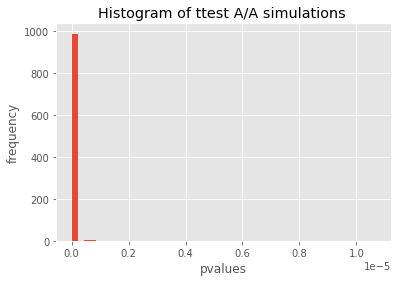

1.0

In [15]:
# v2.8.0: p-value > 0.05, FPR > alpha, соответственно сплит-система работает некорректно и формирует невалидные 
# выборки в данной версии приложения.

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = app[(app.experimentVariant == 0) & (app.version == 'v2.8.0')]['purchase'].sample(n_s, replace = False)
    s2 = app[(app.experimentVariant == 1) & (app.version == 'v2.8.0')]['purchase'].sample(n_s, replace = False)
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) < 0.05) / simulations

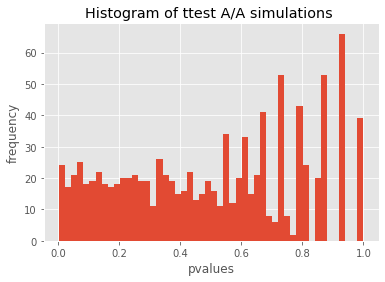

0.046

In [11]:
# v2.9.0: p-value < 0.05, FPR < alpha, соответственно сплит-система работает корректно и формирует валидные выборки.

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = app[(app.experimentVariant == 0) & (app.version == 'v2.9.0')]['purchase'].sample(n_s, replace = False)
    s2 = app[(app.experimentVariant == 1) & (app.version == 'v2.9.0')]['purchase'].sample(n_s, replace = False)
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) < 0.05) / simulations

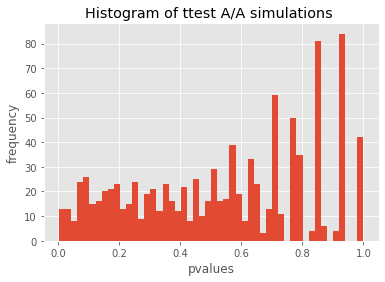

0.029

In [13]:
# v3.7.4.0: p-value < 0.05, FPR < alpha, соответственно сплит-система работает корректно и формирует валидные выборки.

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = app[(app.experimentVariant == 0) & (app.version == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False)
    s2 = app[(app.experimentVariant == 1) & (app.version == 'v3.7.4.0')]['purchase'].sample(n_s, replace = False)
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) < 0.05) / simulations

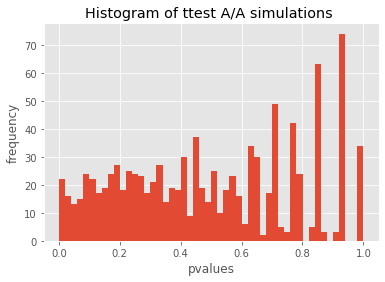

0.045

In [14]:
# v3.8.0.0: p-value < 0.05, FPR < alpha, соответственно сплит-система работает корректно и формирует валидные выборки.

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = app[(app.experimentVariant == 0) & (app.version == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False)
    s2 = app[(app.experimentVariant == 1) & (app.version == 'v3.8.0.0')]['purchase'].sample(n_s, replace = False)
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1])

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

sum(np.array(res) < 0.05) / simulations

Вывод: по результатам А/А теста можно сделать вывод о некорректной работе системы сплитования наблюдений для версии приложения v2.8.0. Для версий v2.9.0, v3.7.4.0 и v3.8.0.0 сплит-системы работают коррректно.

# ответ преподавателя: вы верно решили задание!

Логика решения задачи была верной: вы последовательно сравнивали градации в измерениях по целевой переменной. 


В качестве бонуса, ниже показано альтернативное решение задачи

In [6]:

from statsmodels.stats.proportion import proportions_ztest
df = pd.read_csv('hw_aa.csv', sep=';',index_col=0, decimal=',')
df.head()

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [9]:

# основная функция для расчета АА с синтетическими тестами
def metric_fpr(df_x, df_y, metric_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    stat_res = {
        'aa' : {
            'pvalue': [], 
            'mu_x': [], 
            'mu_y': []
        },
        'fpr': {
            'fpr_95': 0
        }
    }
    
    for sim in range(n_sim):
        
        # по-умолчанию берем %(n_s_perc) наблюдений от исходной, но не более n_s_min
        x = df_x[metric_col].sample(int(min(n_s_min, len(df_x) * n_s_perc)), replace = False).values 
        y = df_y[metric_col].sample(int(min(n_s_min, len(df_y) * n_s_perc)), replace = False).values

        if estimator == 'prop':
            counts = np.array([sum(x),sum(y)])
            nobs = np.array([len(x),len(y)])
            stat, pvalue = proportions_ztest(counts, nobs, *args, **kwargs)
        
        if estimator == 'ttest':
            stat, pvalue = stats.ttest_ind(x, y, *args, **kwargs)
            
        stat_res['aa']['pvalue'].append(pvalue)
        stat_res['aa']['mu_x'].append(np.mean(x))
        stat_res['aa']['mu_y'].append(np.mean(y))
        
    
    stat_res['fpr']['fpr_95'] =  float(sum(np.array(stat_res['aa']['pvalue']) <= 0.05) / n_sim)
    
    return stat_res

# считаем АА по градациям внутри измерений (группировок)
def fpr_report(df, metric_col, variant_col, group_col, n_sim, n_s_perc, n_s_min, estimator, *args, **kwargs):
    list_fpr = []
    list_group = list(pd.unique(df[group_col]))
    
    for v in range(len(list_group)):
        df_x = df[(df[variant_col] == 0) & (df[group_col] == list_group[v])]
        df_y = df[(df[variant_col] == 1) & (df[group_col] == list_group[v])]
        
        if (len(df_x) == 0) | (len(df_y) == 0):
            continue
        else:
            cr_x = sum(df_x[metric]) / len(df_x)
            cr_y = sum(df_y[metric]) / len(df_y)

            fpr = {}
            fpr = metric_fpr(
                df_x = df_x, 
                df_y = df_y, 
                metric_col = metric, 
                n_sim = n_sim,
                n_s_perc = n_s_perc,
                n_s_min = n_s_min,
                estimator = estimator, *args, **kwargs
            )
            is_fpr = (fpr['fpr']['fpr_95']<=0.05)
            list_fpr.append([list_group[v],cr_x,cr_y,fpr['fpr']['fpr_95'],is_fpr])

    report = pd.DataFrame.from_records(list_fpr, columns=['group','cr_x','cr_y','fpr_95','is_fpr'])
    
    return report

# параметры
n_sim = 500 # количество симуляций
n_s_perc = 0.9 # % наблюдений в подвыборках
n_s_min = 1000 # но не более константы
metric = 'purchase'
variant = 'experimentVariant'
group = 'version'

res = fpr_report(
    df = df,
    metric_col = metric,
    variant_col = variant,
    group_col = group,
    n_sim = n_sim,
    n_s_perc = n_s_perc,
    n_s_min = n_s_min,
    estimator = 'prop'
)

res

/Users/iskander/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/weightstats.py:671: RuntimeWarning: invalid value encountered in double_scalars
  zstat = value / std_diff
/Users/iskander/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in less_equal


,group,cr_x,cr_y,fpr_95,is_fpr
0,3.8.2.0,0.066557,0.067081,0.044,True
1,2.8.0,0.000000,0.045606,1.000,False
2,2.9.0,0.074658,0.071304,0.044,True
3,3.7.4.0,0.059943,0.063018,0.038,True
4,3.8.0.0,0.057604,0.062848,0.046,True
5,3.8.3.0,0.060475,0.052519,0.000,True
6,3.8.1.0,0.000000,0.000000,0.000,True
7,3.7.2.0,0.000000,0.000000,0.000,True


Видим, что проблемы в 2.8.0 версии. По сути мы могли бы итерироваться по другим измерениям и в конце концов нашли бы причину на самом низком уровне

In [8]:
np.random.seed(1)
group = 'operatingSystem'
df_fltrd = df[(df['version']!='2.8.0')]

res = fpr_report(
    df = df_fltrd,
    metric_col = metric,
    variant_col = variant,
    group_col = group,
    n_sim = n_sim,
    n_s_perc = n_s_perc,
    n_s_min = n_s_min,
    estimator = 'prop'
)

res


,group,cr_x,cr_y,fpr_95,is_fpr
0,ANDROID,0.065903,0.066633,0.038,True
1,IOS,0.074658,0.071292,0.044,True
